# Dollar relationship with twin deficits 

In this post, we will examine the relationship between dollar and twin deficits.

In [1]:
# import prelude as usual
from prelude import *
import matplotlib.dates as mdates

## Prepare twin deficits and GDP data

Twin deficits consists of trade account deficit and government fiscal deficit. [FRED](https://fred.stlouisfed.org/)
offers both data series at monthly frequency.

In [2]:
df = fred_reader_multi({
    'trade_deficit': 'BOPGSTB',
    'gov_deficit': 'MTSDS133FMS'
})
df.insert(0, 'twin_deficit', df.trade_deficit + df.gov_deficit)

FRED also offers quarterly GDP data points. Together with 

In [3]:
twi_start_date = datetime.datetime(1992, 12, 1)
twi_dollar_major = fred_reader_series('DTWEXM')[twi_start_date:]
dxy = yahoo_reader('DX-Y.NYB').Close

qdf = df.resample('Q').sum()
# normalize to million and align time with deficit data
billion_to_million = 1_000_000_000 / 1_000_000
qgdp = fred_reader('GDP').shift(3, 'M').GDP * billion_to_million
# Quarterly reading, Seasonally Adjusted Annual Rate
qdf.insert(0, 'quarterly_annual_GDP', qgdp)
qdf = qdf.dropna()
qdf.insert(2, 'twin_deficit_annual_adjusted', qdf.twin_deficit.rolling(4).sum())
qdf.insert(2, 'twin_deficit_pct_GDP', qdf.twin_deficit_annual_adjusted / qdf.quarterly_annual_GDP * 100.0)
qdf = qdf.dropna()

In [4]:
qdf

quarterly_annual_GDP  twin_deficit  twin_deficit_pct_GDP  \
DATE                                                                   
1992-12-31             6680803.0 -1.335560e+05             -5.481362   
1993-03-31             6729459.0 -7.689900e+04             -4.785526   
1993-06-30             6808939.0 -3.579000e+04             -4.693683   
1993-09-30             6882098.0 -7.313200e+04             -4.640692   
1993-12-31             7013738.0 -1.108370e+05             -4.229670   
...                          ...           ...                   ...   
2020-03-31            21561139.0 -5.166837e+05             -7.411954   
2020-06-30            19520114.0 -2.161433e+06            -18.193463   
2020-09-30            21170252.0 -5.790953e+05            -17.683065   
2020-12-31            21494731.0 -7.728841e+05            -18.749228   
2021-03-31            22048894.0 -1.346135e+06            -22.039870   

            twin_deficit_annual_adjusted  trade_deficit   gov_deficit  
DATE                                                                   
1992-12-31                 -3.661990e+05       -13091.0 -1.204650e+05  
1993-03-31                 -3.220400e+05       -14244.0 -6.265500e+04  
1993-06-30                 -3.195900e+05       -17743.0 -1.804700e+04  
1993-09-30                 -3.193770e+05       -18994.0 -5.413800e+04  
1993-12-31                 -2.966580e+05       -19329.0 -9.150800e+04  
...                                  ...            ...           ...  
2020-03-31                 -1.598102e+06      -129630.0 -3.870537e+05  
2020-06-30                 -3.551385e+06      -160687.0 -2.000746e+06  
2020-09-30                 -3.743549e+06      -191398.0 -3.876973e+05  
2020-12-31                 -4.030096e+06      -199985.0 -5.728991e+05  
2021-03-31                 -4.859548e+06      -212789.0 -1.133346e+06  

[114 rows x 6 columns]

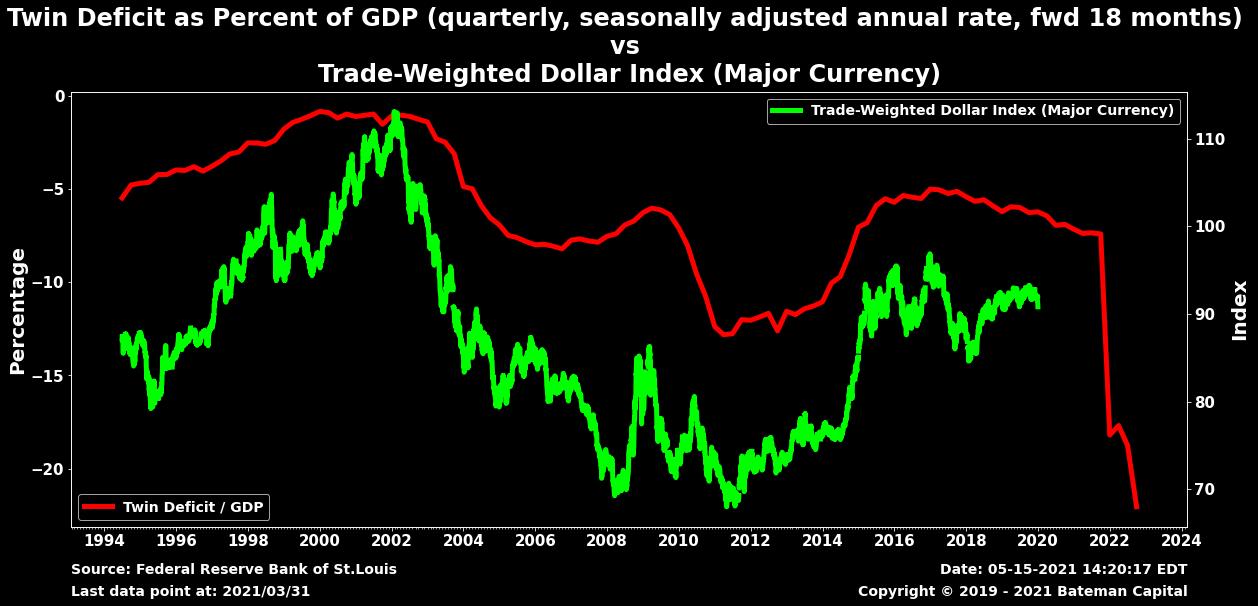

In [5]:
def plot_deficit_vs_dollar(dollar, dollar_label, start_date=twi_start_date):
    fig, ax = plt.subplots()
    # forward 18 years
    twin_deficit = qdf.twin_deficit_pct_GDP.shift(6, freq='Q')
    start_date = max(start_date, twin_deficit.index[0], dollar.index[0])
    dollar = dollar[start_date:]
    twin_deficit = twin_deficit[start_date:]
    ax.plot(twin_deficit, label='Twin Deficit / GDP', color='red')
    ax.legend(loc='lower left')
    ax.set_ylabel('Percentage')
    ax2 = ax.twinx()
    ax2.plot(dollar,
             label=dollar_label,
             color='lime')
    ax2.set_ylabel('Index')
    ax2.legend(loc='upper right')
    ax2.xaxis.set_major_locator(mdates.YearLocator(2))
    ax2.xaxis.set_minor_locator(mdates.MonthLocator())
    ax2.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
    add_source(ax, 'Federal Reserve Bank of St.Louis')
    plt.title('Twin Deficit as Percent of GDP (quarterly, seasonally adjusted annual rate, fwd 18 months) \nvs \n{}'.format(dollar_label))
    last = qdf.index[-1]
    plt.text(0, -0.15, 'Last data point at: ' + last.strftime('%Y/%m/%d'),
          horizontalalignment='left',
          verticalalignment='center',
          fontsize=14,
          transform = ax.transAxes)

plot_deficit_vs_dollar(twi_dollar_major, 'Trade-Weighted Dollar Index (Major Currency)')

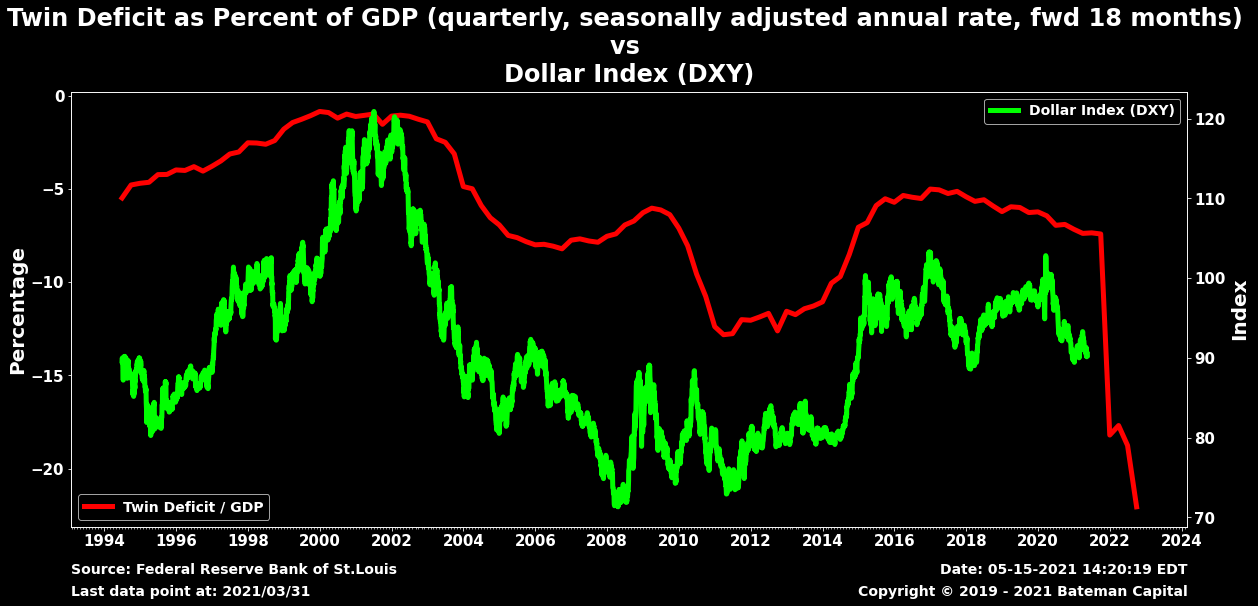

In [6]:
plot_deficit_vs_dollar(dxy, 'Dollar Index (DXY)')

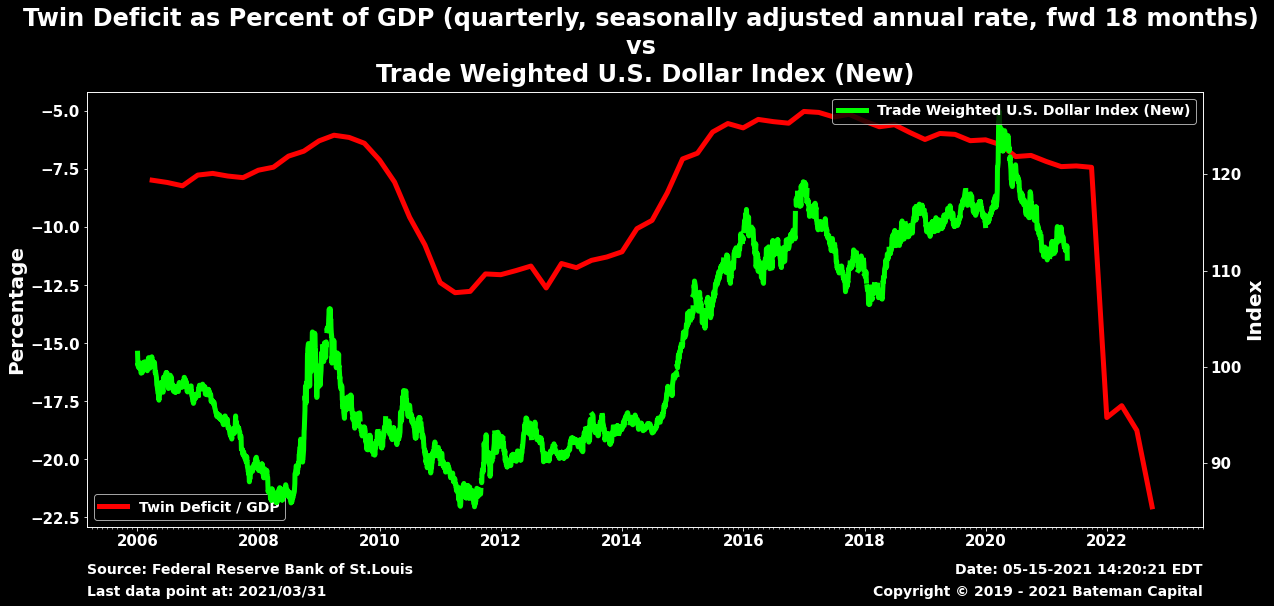

In [7]:
twi_new = fred_reader_series('DTWEXBGS')
plot_deficit_vs_dollar(twi_new, 'Trade Weighted U.S. Dollar Index (New)')

In [8]:
def calc_corr(ldf):
    return pd.Series.corr(ldf.dollar, ldf.symbol)


# sensitivity: price change / dollar change
# mean of rolling 180 days
def calc_sensitivity(ldf):
    deltas = ldf.rolling(30).apply(lambda s: s[-1] - s[0]).dropna()
    change_ratio = (deltas.symbol / deltas.dollar).dropna()
    with pd.option_context('mode.use_inf_as_na', True):
        change_ratio = change_ratio.dropna()
    return change_ratio.mean()


def compare_dollar_ax(ax, ldf, symbol, dollar_symbol):
    ax.invert_yaxis()
    ax.plot(ldf.dollar, label=dollar_symbol, color='lime')
    ax.set_ylabel(dollar_symbol)
    ax2 = ax.twinx()
    ax2.set_ylabel(f'{symbol} $')
    sn = '$' + symbol
    ax2.plot(ldf.symbol, color='orange')
    corr = calc_corr(ldf)
    ax.title.set_text(f'{dollar_symbol} (inverted) vs {sn}')
    cr_mean = calc_sensitivity(ldf)
    ax.text(0, -0.16, 'corr: {:6.2f}'.format(corr),
             horizontalalignment='left',
             verticalalignment='center',
             fontsize=14,
             transform=ax.transAxes)
    ax.text(0, -0.23, 'sensitivity mean: {:6.2f}'.format(cr_mean),
             horizontalalignment='left',
             verticalalignment='center',
             fontsize=14,
             transform=ax.transAxes)
    return None


def create_df(s, dollar, start_date):
    return pd.DataFrame({'dollar': dollar,
                         'symbol': yahoo_reader(s, start_date).Close}).dropna()


def compare_dollar(s, dollar=('DXY', dxy), start_date=start):
    dollar_symbol, dollar_series = dollar
    symbols = s if type(s) is list else [s]
    rows = len(symbols)
    fig, axes = plt.subplots(rows, 1, figsize=(20, rows * 5))
    # workaround subplots API
    if rows == 1:
        axes = [axes]
    plt.subplots_adjust(hspace=0.4)
    ldfs = [create_df(s, dollar_series, start_date) for s in symbols]
    ldfs_with_symbols = list(zip(ldfs, symbols))
    # highly neg correlated comes first
    ldfs_with_symbols.sort(key=lambda ldf_s: calc_corr(ldf_s[0]))
    for ldfs, ax in zip(ldfs_with_symbols, axes):
        ldf = ldfs[0]
        symbol = ldfs[1]
        compare_dollar_ax(ax, ldf, symbol, dollar_symbol)
    return

## ETF/Stock/FX correlation with DXY

In [9]:
def split_multi(s):
    return [sub for sub in s.split('\n') if sub]

### Industry sector ETF

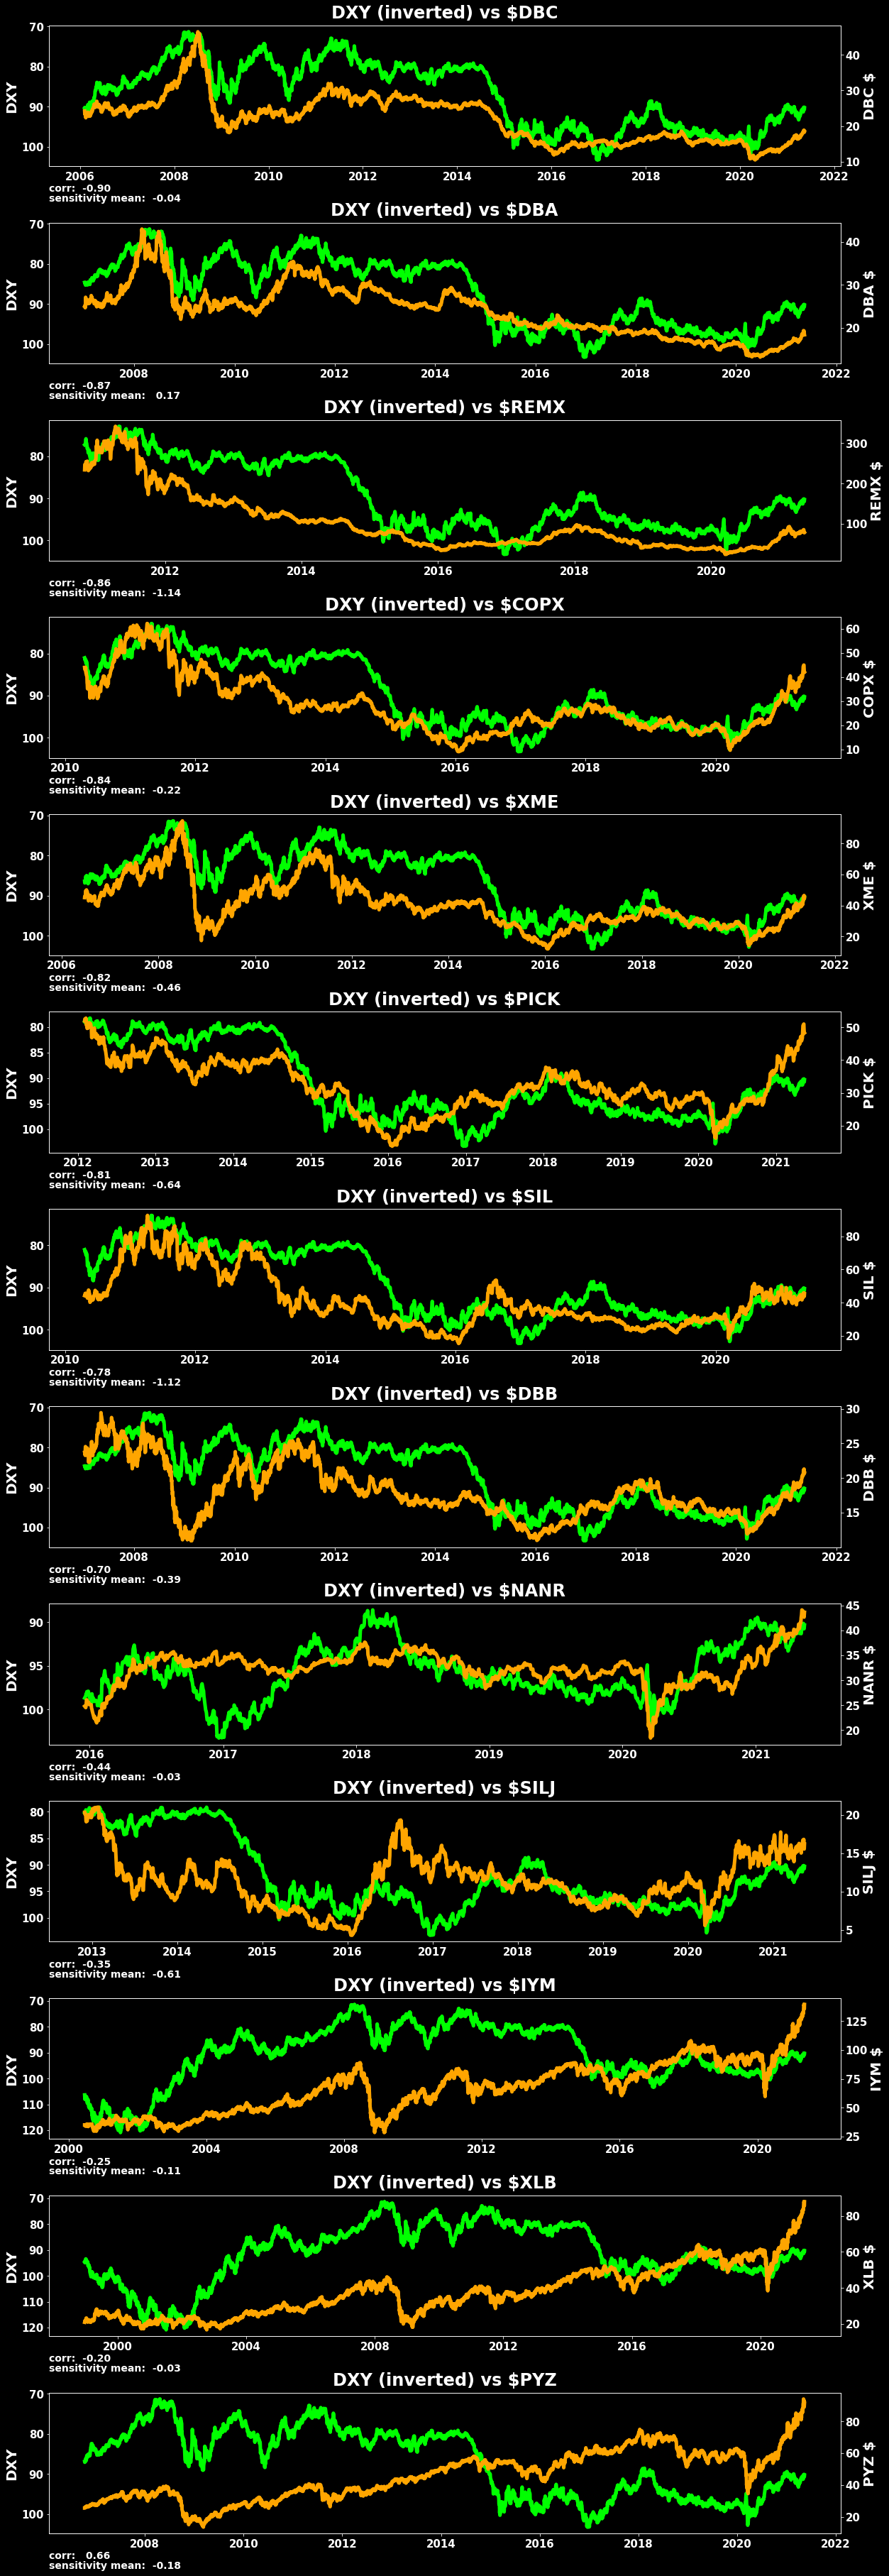

In [10]:
sector_etfs = """
XME
XLB
DBC
DBA
DBB
COPX
PICK
SIL
SILJ
REMX
IYM
NANR
PYZ
"""

compare_dollar(split_multi(sector_etfs))

### Emerging country ETFs

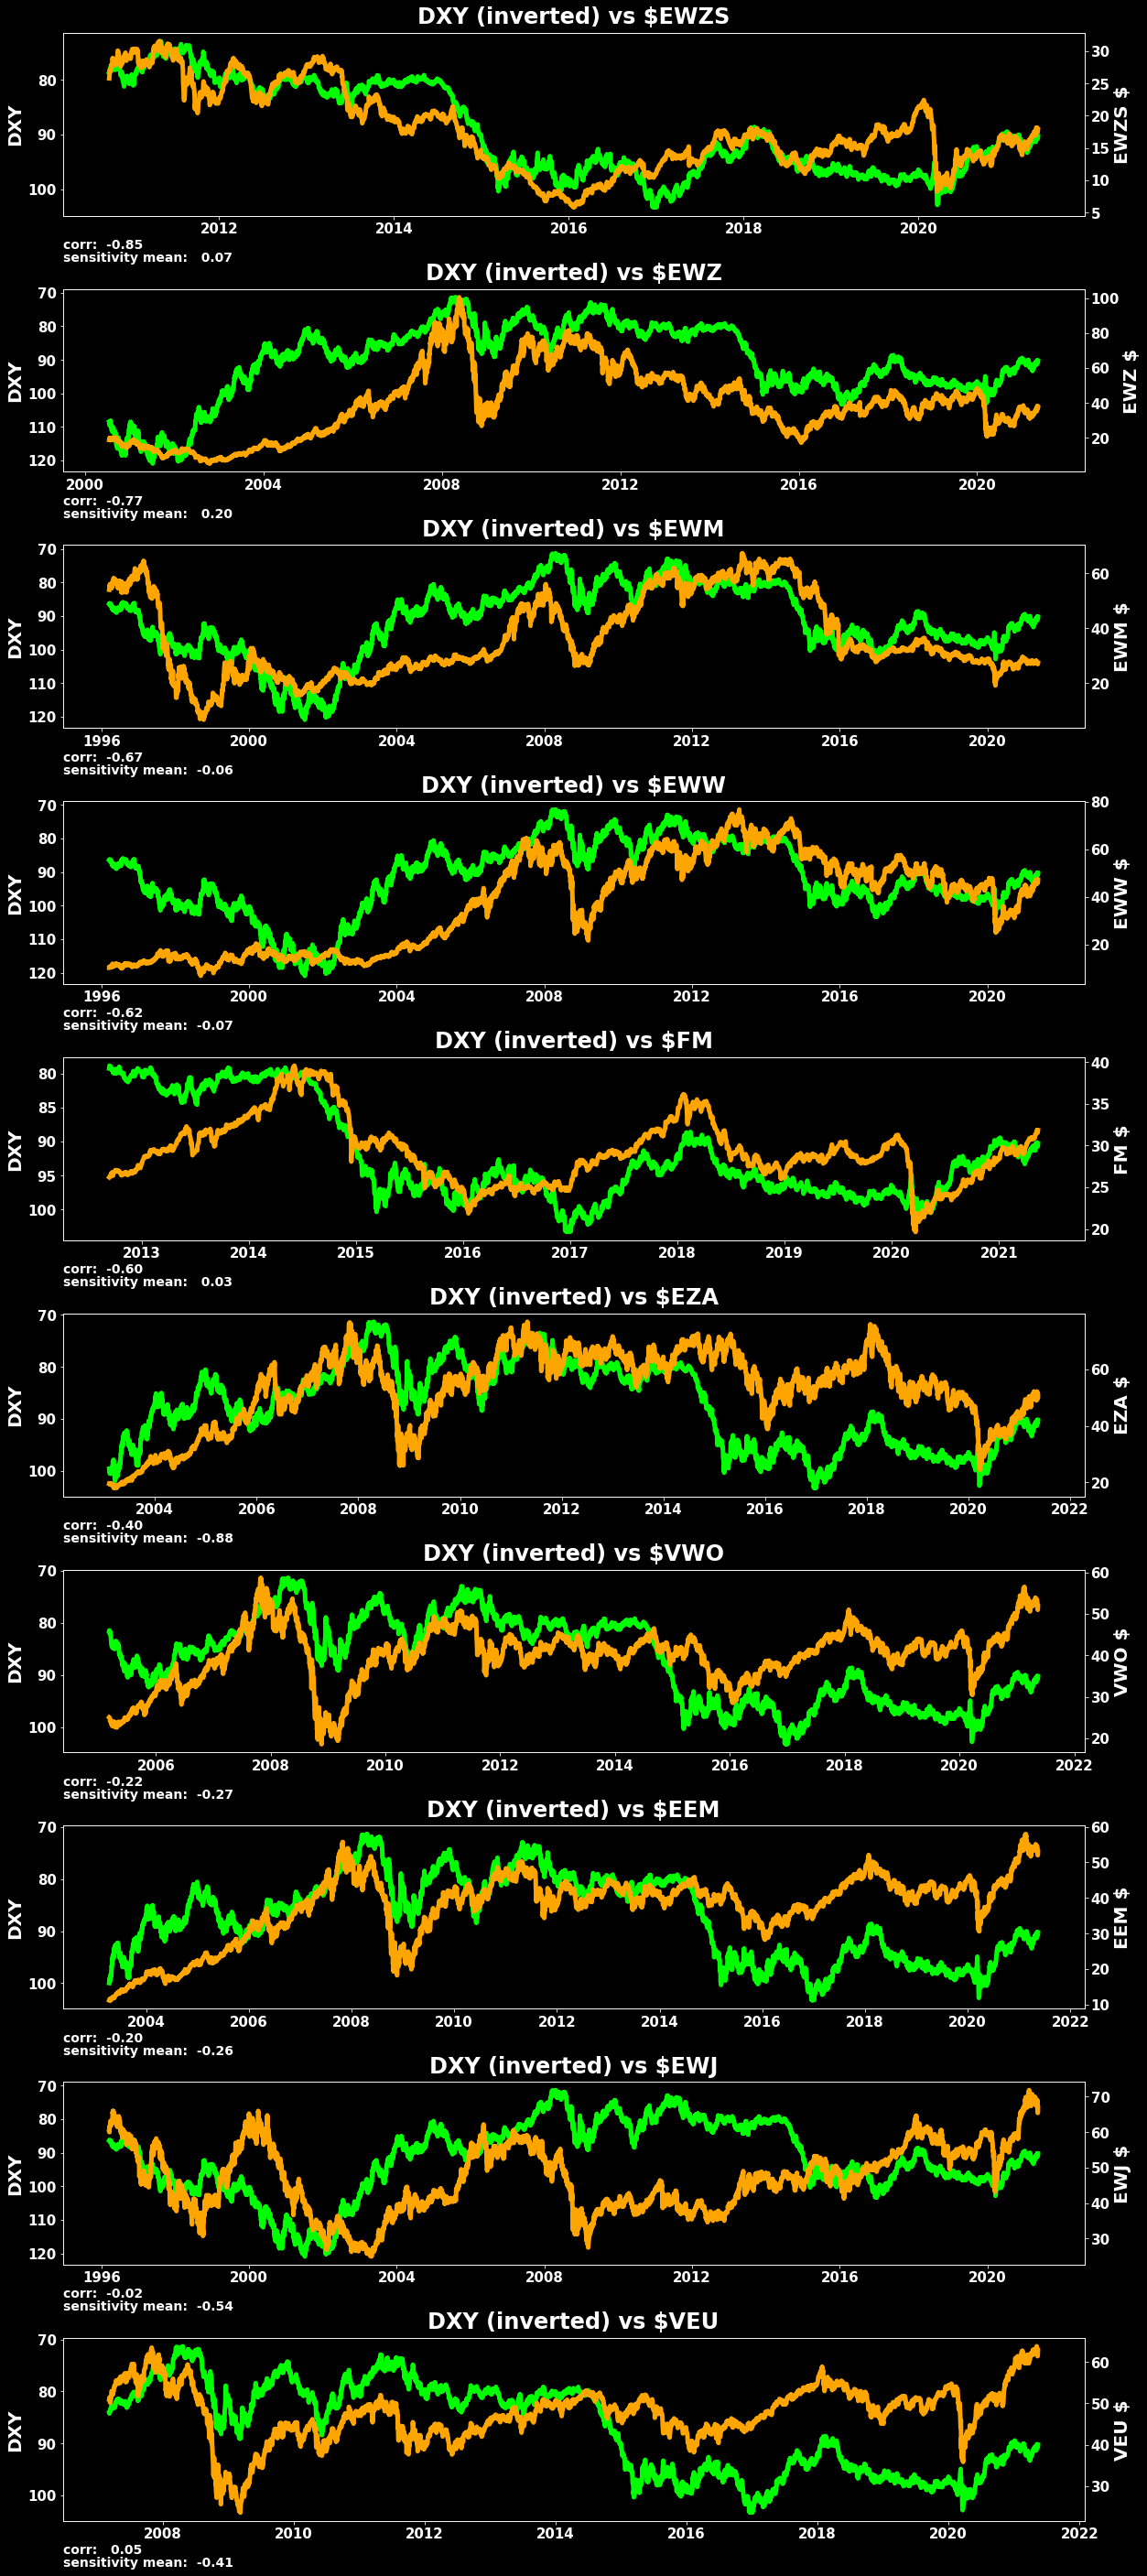

In [11]:
country_etfs = """
EEM
EWZ
EWW
EZA
EWM
EWZS
VWO
FM
VEU
EWJ
"""
compare_dollar(split_multi(country_etfs))

### Individual stocks

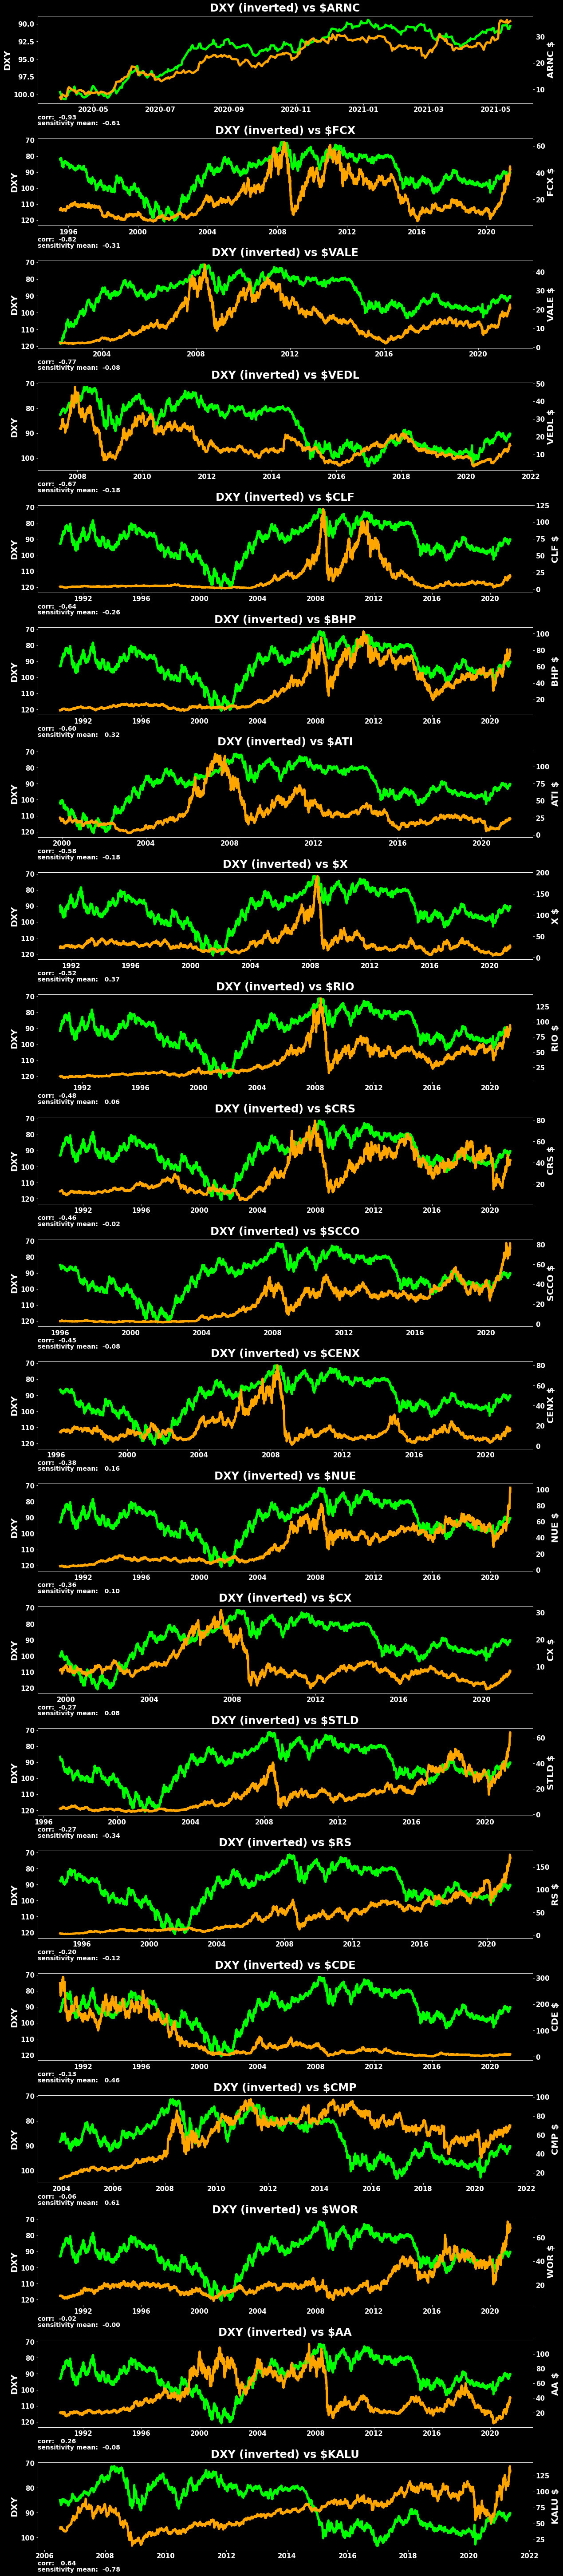

In [12]:
stocks = """
FCX
VALE
BHP
RIO
CX
SCCO
X
CLF
ATI
AA
ARNC
KALU
CRS
WOR
STLD
CENX
NUE
CMP
RS
CDE
VEDL
"""

compare_dollar(split_multi(stocks))

### FX

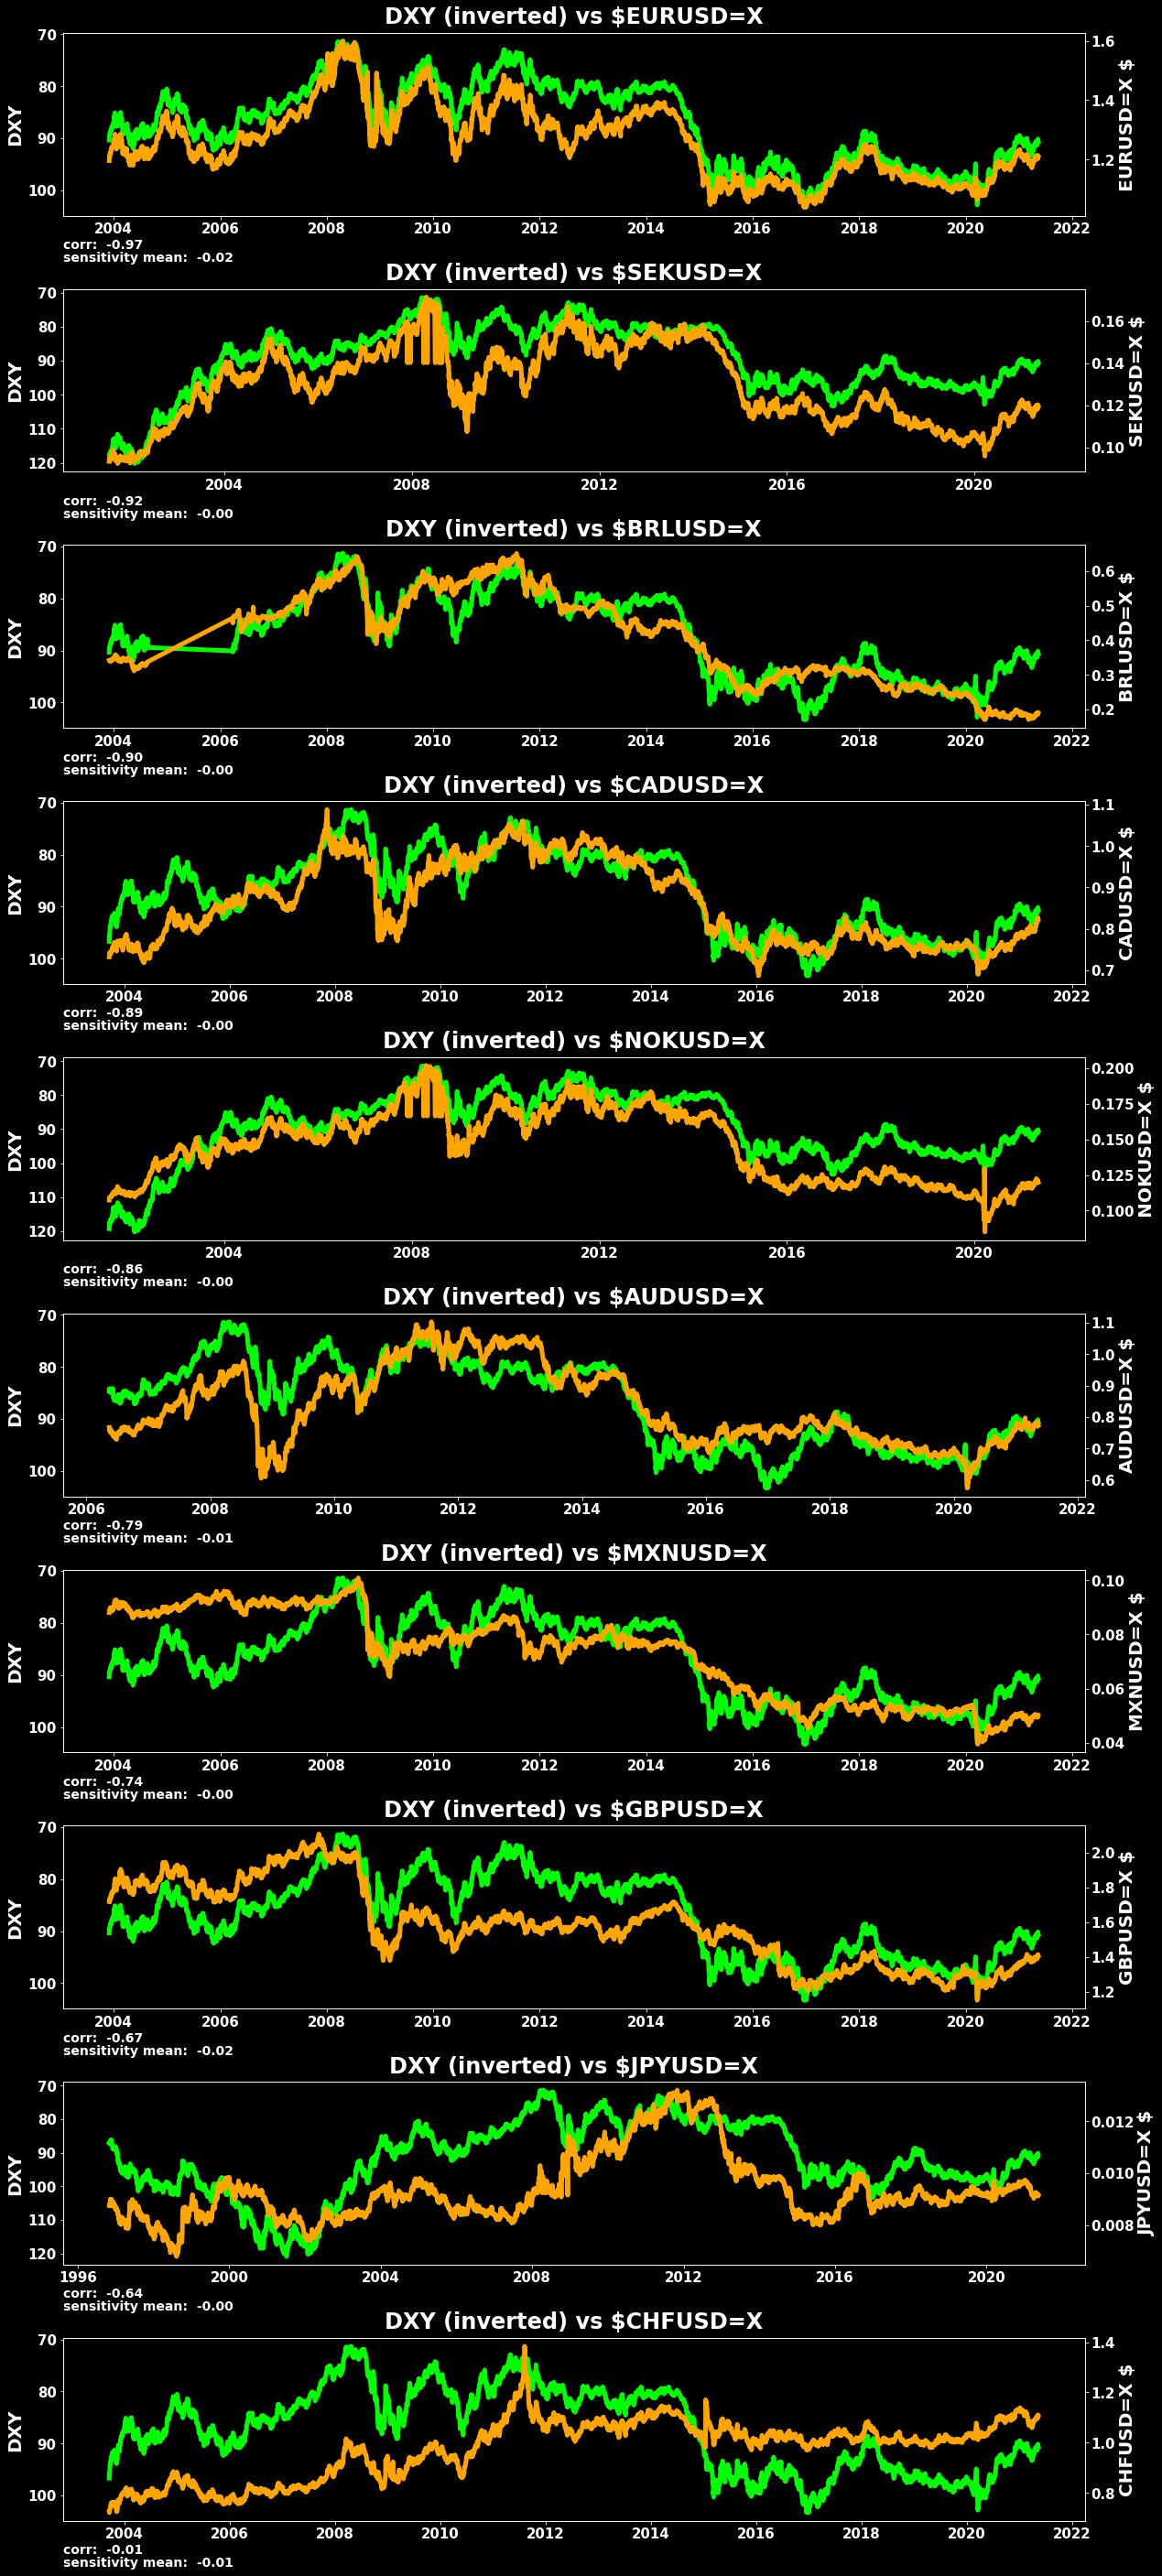

In [13]:
fx = """
SEKUSD=X
AUDUSD=X
CADUSD=X
EURUSD=X
NOKUSD=X
JPYUSD=X
GBPUSD=X
CHFUSD=X
BRLUSD=X
MXNUSD=X
"""

compare_dollar(split_multi(fx))

## ETF XME holdings

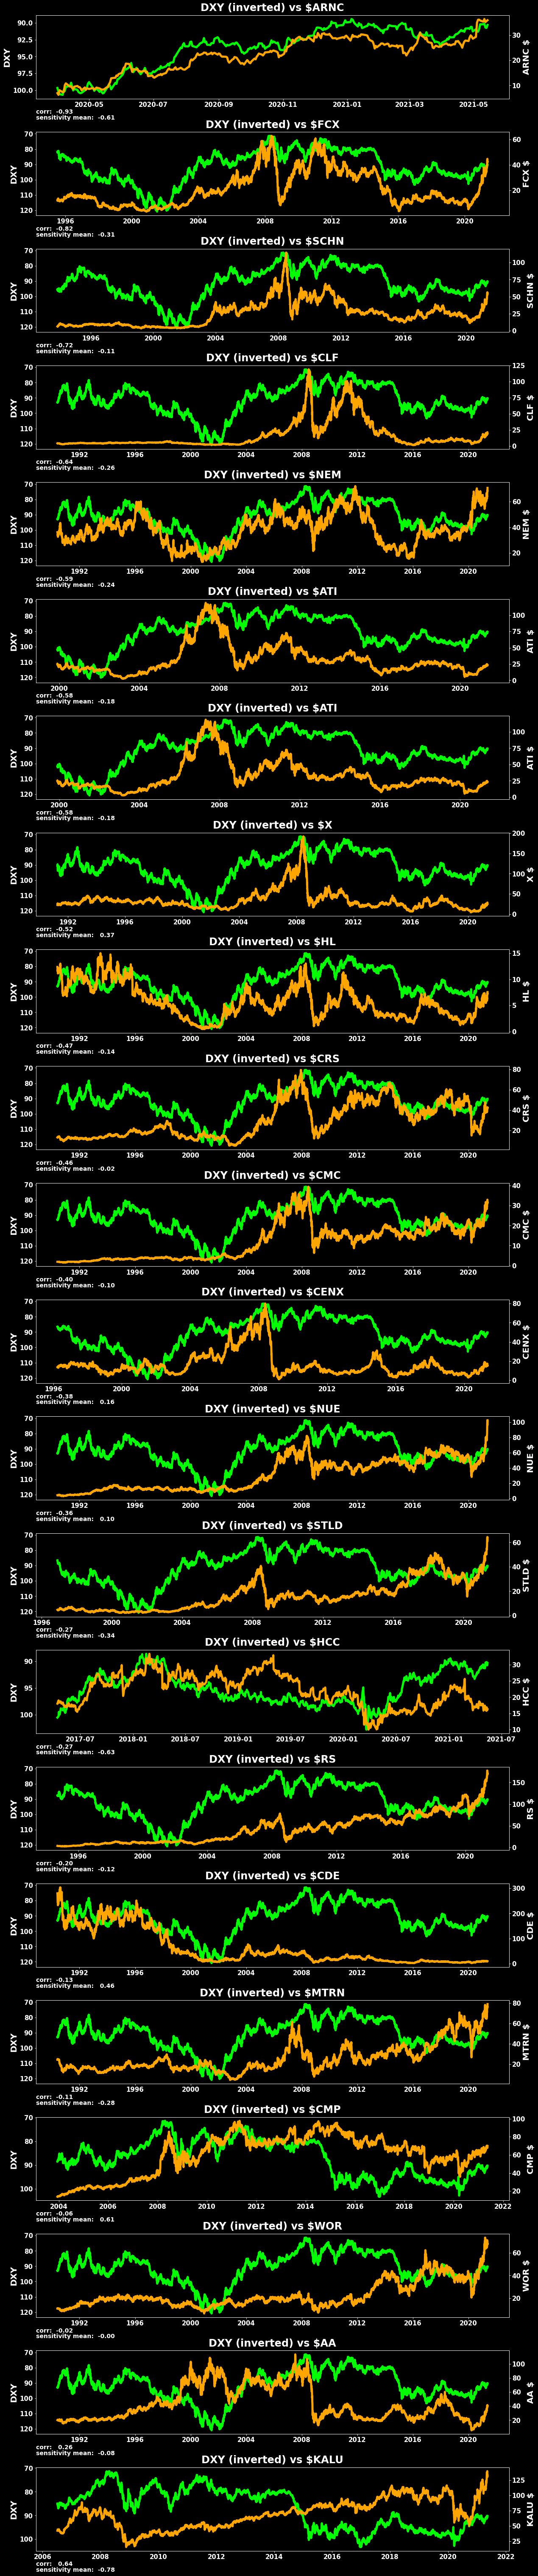

In [14]:
xme_holdings = """
HL
CDE
HCC
CLF
FCX
KALU
CRS
CMC
NEM
ATI
AA
CMP
WOR
RS
ARNC
ATI
X
STLD
CENX
NUE
MTRN
SCHN
"""

compare_dollar(split_multi(xme_holdings))


In [15]:
','.join(split_multi(xme_holdings))

'HL,CDE,HCC,CLF,FCX,KALU,CRS,CMC,NEM,ATI,AA,CMP,WOR,RS,ARNC,ATI,X,STLD,CENX,NUE,MTRN,SCHN'